# data preparation
run code/prepare_dataset.py

In [ ]:
import importlib.util
spec = importlib.util.spec_from_file_location('prepare_dataset', 'code/prepare_dataset.py')
prepare_dataset = importlib.util.module_from_spec(spec)
spec.loader.exec_module(prepare_dataset)

prepare_dataset.main()

In [2]:
import polars as pl
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from pathlib import Path

# Load both datasets
FINAL_INDIVIDUAL_PATH = Path("data/processed/model/final_dataset_individual.parquet")
FINAL_ZIPCODE_PATH = Path("data/processed/model/final_dataset_zipcode.parquet")

df_individual = pl.read_parquet(FINAL_INDIVIDUAL_PATH).to_pandas()
df_zipcode = pl.read_parquet(FINAL_ZIPCODE_PATH).to_pandas()

print(f"Individual dataset loaded: {df_individual.shape}")
print(f"Zipcode dataset loaded: {df_zipcode.shape}")

Individual dataset loaded: (117582, 645)
Zipcode dataset loaded: (340, 276)


array([[<Axes: title={'center': 'extraversion_mean'}>,
        <Axes: title={'center': 'agreeableness_mean'}>],
       [<Axes: title={'center': 'conscientiousness_mean'}>,
        <Axes: title={'center': 'neuroticism_mean'}>],
       [<Axes: title={'center': 'openness_mean'}>, <Axes: >]],
      dtype=object)

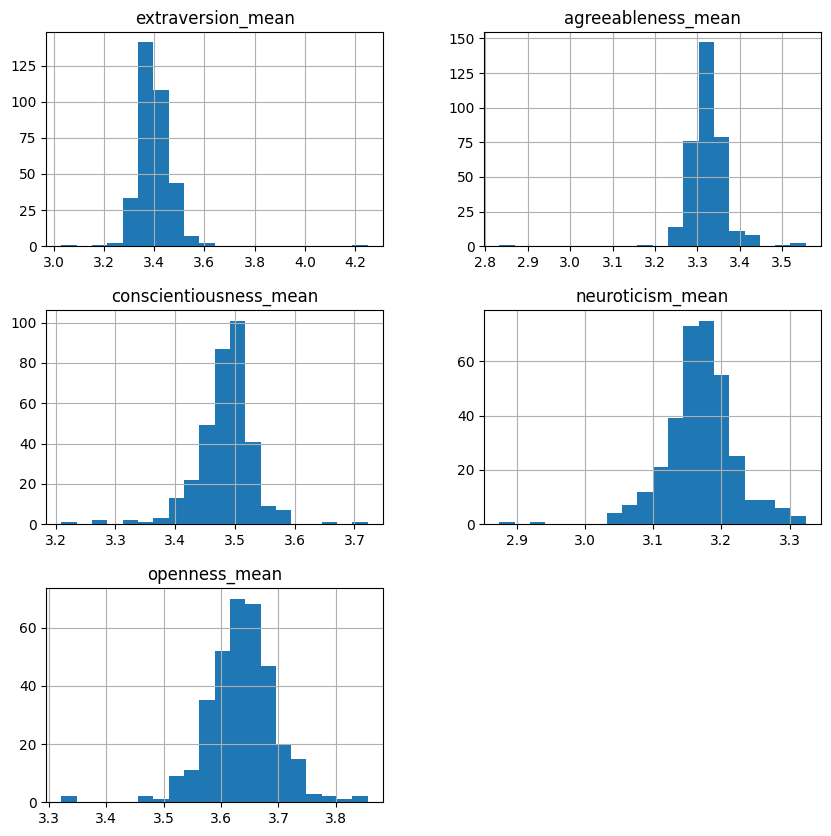

In [8]:
# quick histogram of the target variable (those that include  ['extraversion', 'agreeableness', 'conscientiousness', 'neuroticism', 'openness'])
df_zipcode[['extraversion_mean', 'agreeableness_mean', 'conscientiousness_mean', 'neuroticism_mean', 'openness_mean']].hist(bins=20, figsize=(10, 10))

<Axes: >

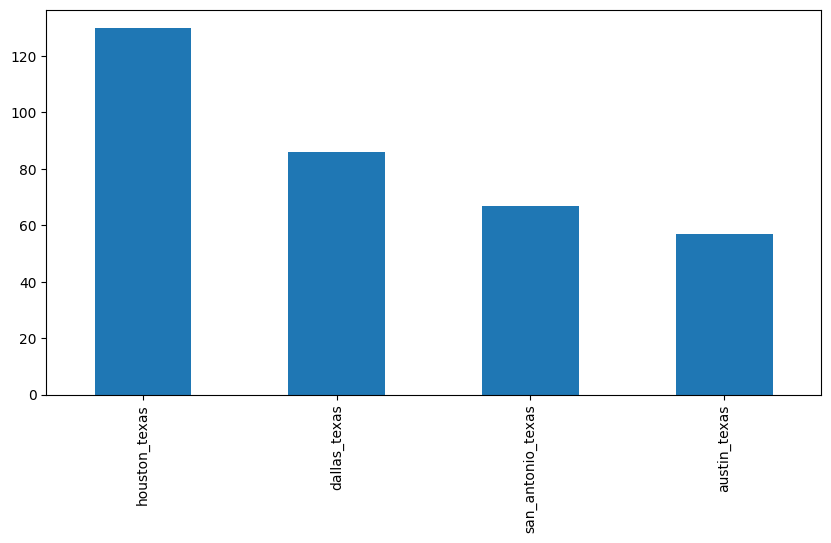

In [9]:
df_zipcode["city"].value_counts().plot(kind='bar', figsize=(10, 5))

In [3]:
# Define control variables with low missing rates
control_vars = [
    'age',              # 0.16% missing
    'female',           # 0.10% missing
    'ethnic',           # 5.31% missing
    'edu_own',          # 3.50% missing
    'time_now',         # 3.37% missing
]

# Get street view indicator columns for individual data
individual_street_view_cols = [
    col for col in df_individual.columns 
    if ('_ratios' in col or '_counts' in col) or col == 'visual_complexity'
]

# Get street view indicator columns for zipcode data (including means and stds)
zipcode_street_view_cols = [
    col for col in df_zipcode.columns 
    if (col.endswith(('_mean', '_std')) and 
        not any(trait in col for trait in ['extraversion', 'agreeableness', 'conscientiousness', 'neuroticism', 'openness']))
]

# Big Five traits
traits = ['extraversion', 'agreeableness', 'conscientiousness', 'neuroticism', 'openness']
zipcode_traits = [f"{trait}_mean" for trait in traits] + [f"{trait}_std" for trait in traits]

# Prepare predictor variables
individual_X_cols = control_vars + individual_street_view_cols
zipcode_X_cols = zipcode_street_view_cols  # No control vars at zipcode level

def run_regression(df, X_cols, y_col):
    """Run regression and format results"""
    # Drop rows with missing values
    analysis_df = df[X_cols + [y_col]].dropna()
    print(f"X_cols: {X_cols}")
    print(f"y_col: {y_col}")
    
    # Standardize all variables
    scaler = StandardScaler()
    X = scaler.fit_transform(analysis_df[X_cols])
    y = scaler.fit_transform(analysis_df[[y_col]])
    
    # Add constant for statsmodels
    X = sm.add_constant(X)
    
    # Fit model
    model = sm.OLS(y, X)
    results = model.fit()
    
    # Create results DataFrame
    coef_df = pd.DataFrame({
        'variable': ['constant'] + X_cols,
        'coefficient': results.params,
        'std_err': results.bse,
        't_value': results.tvalues,
        'p_value': results.pvalues
    })
    
    # Add significance stars
    coef_df['significance'] = coef_df['p_value'].apply(lambda p: 
        '***' if p < 0.001 else
        '**' if p < 0.01 else
        '*' if p < 0.05 else
        '.' if p < 0.1 else '')
    
    # Add model fit statistics
    fit_stats = pd.Series({
        'R-squared': results.rsquared,
        'Adj. R-squared': results.rsquared_adj,
        'F-statistic': results.fvalue,
        'Prob (F-statistic)': results.f_pvalue,
        'N observations': results.nobs
    })
    
    return coef_df, fit_stats

In [17]:
# Run regressions for zipcode-level data
print("Running Zipcode-Level Regressions...")
zipcode_results = {}

# Run regressions for both mean and std of each trait
for trait_stat in zipcode_traits:
    print(f"\nAnalyzing {trait_stat}...")
    coef_df, fit_stats = run_regression(df_zipcode, zipcode_X_cols, trait_stat)
    
    zipcode_results[trait_stat] = {
        'coefficients': coef_df,
        'fit_stats': fit_stats
    }
    
    # Print summary
    print("\nModel Fit Statistics:")
    print(fit_stats)
    
    print("\nSignificant Street View Indicators (p < 0.05):")
    sig_street_view = coef_df[
        (coef_df['variable'].isin(zipcode_street_view_cols)) & 
        (coef_df['p_value'] < 0.05)
    ][['variable', 'coefficient', 'p_value', 'significance']]
    print(sig_street_view.to_string(index=False))

    # Save summary to a text file
    summary_file = Path('results/regression_zipcode') / f"{trait_stat}_summary.txt"
    summary_file.parent.mkdir(parents=True, exist_ok=True)
    
    with summary_file.open('w') as file:
        file.write("Model Fit Statistics:\n")
        file.write(fit_stats.to_string())
        
        file.write("\nSignificant Street View Indicators (p < 0.05):\n")
        file.write(sig_street_view.to_string(index=False))
    
    # Save results
    output_dir = Path('results/regression_zipcode')
    output_dir.mkdir(parents=True, exist_ok=True)
    
    coef_df.to_csv(output_dir / f"{trait_stat}_coefficients.csv", index=False)
    fit_stats.to_frame().to_csv(output_dir / f"{trait_stat}_fit_stats.csv")

Running Zipcode-Level Regressions...

Analyzing extraversion_mean...
X_cols: ['Bird_ratios_mean', 'Curb_ratios_mean', 'Road_ratios_mean', 'Sidewalk_ratios_mean', 'Building_ratios_mean', 'Sky_ratios_mean', 'Terrain_ratios_mean', 'Vegetation_ratios_mean', 'Utility Pole_ratios_mean', 'Car_ratios_mean', 'Person_ratios_mean', 'Pole_ratios_mean', 'Barrier_ratios_mean', 'Lane Marking - General_ratios_mean', 'Traffic Sign (Back)_ratios_mean', 'Wall_ratios_mean', 'Fence_ratios_mean', 'Billboard_ratios_mean', 'Catch Basin_ratios_mean', 'Traffic Sign (Front)_ratios_mean', 'Street Light_ratios_mean', 'Motorcycle_ratios_mean', 'Truck_ratios_mean', 'Rail Track_ratios_mean', 'Manhole_ratios_mean', 'Mountain_ratios_mean', 'Trash Can_ratios_mean', 'Guard Rail_ratios_mean', 'Bridge_ratios_mean', 'Trailer_ratios_mean', 'Traffic Sign Frame_ratios_mean', 'Other Vehicle_ratios_mean', 'Fire Hydrant_ratios_mean', 'Curb Cut_ratios_mean', 'Snow_ratios_mean', 'Junction Box_ratios_mean', 'Traffic Light_ratios_mea

In [18]:
df_zipcode.head()

,now_zip,participant_count,extraversion_mean,agreeableness_mean,conscientiousness_mean,neuroticism_mean,openness_mean,extraversion_std,agreeableness_std,conscientiousness_std,...,CCTV Camera_counts_std,Bike Lane_ratios_std,Phone Booth_ratios_std,Bike Lane_counts_std,Phone Booth_counts_std,Crosswalk - Plain_ratios_std,Crosswalk - Plain_counts_std,Bike Rack_ratios_std,Bike Rack_counts_std,visual_complexity_std
0,77028,77,3.537338,3.354257,3.466089,3.215909,3.638961,0.417082,0.440403,0.433355,...,0.006114,0.000000,0.000143,0.000000,0.010589,0.0,0.0,0.000000,0.000000,0.134918
1,75237,123,3.485772,3.298103,3.399277,3.099593,3.636585,0.406531,0.326684,0.387739,...,0.011924,0.002886,0.000076,0.016862,0.011924,0.0,0.0,0.000000,0.000000,0.171630
2,77079,372,3.362231,3.326874,3.494325,3.188508,3.621505,0.402889,0.353959,0.348131,...,0.015251,0.000205,0.000059,0.022322,0.008153,0.0,0.0,0.000000,0.000000,0.180284
3,77506,200,3.398750,3.318403,3.494444,3.100625,3.577500,0.446825,0.462855,0.400501,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.529505
4,78217,334,3.363772,3.351838,3.507984,3.214446,3.673054,0.393816,0.361666,0.367848,...,0.021472,0.000259,0.000018,0.005369,0.005369,0.0,0.0,0.000011,0.005369,0.143915


In [19]:
# Run regressions for zipcode-level data
print("Running Zipcode-Level Regressions...")
zipcode_results = {}

# Run regressions for both mean and std of each trait
for trait_stat in zipcode_traits:
    print(f"\nAnalyzing {trait_stat}...")
    coef_df, fit_stats = run_regression(df_zipcode, zipcode_X_cols, trait_stat)
    
    zipcode_results[trait_stat] = {
        'coefficients': coef_df,
        'fit_stats': fit_stats
    }
    
    # Print summary
    print("\nModel Fit Statistics:")
    print(fit_stats)
    
    print("\nSignificant Street View Indicators (p < 0.05):")
    sig_street_view = coef_df[
        (coef_df['variable'].isin(zipcode_street_view_cols)) & 
        (coef_df['p_value'] < 0.05)
    ][['variable', 'coefficient', 'p_value', 'significance']]
    print(sig_street_view.to_string(index=False))

    # Save summary to a text file
    summary_file = Path('results/regression_zipcode') / f"{trait_stat}_summary.txt"
    summary_file.parent.mkdir(parents=True, exist_ok=True)
    
    with summary_file.open('w') as file:
        file.write("Model Fit Statistics:\n")
        file.write(fit_stats.to_string())
        
        file.write("\nSignificant Street View Indicators (p < 0.05):\n")
        file.write(sig_street_view.to_string(index=False))
    
    # Save results
    output_dir = Path('results/regression_zipcode')
    output_dir.mkdir(parents=True, exist_ok=True)
    
    coef_df.to_csv(output_dir / f"{trait_stat}_coefficients.csv", index=False)
    fit_stats.to_frame().to_csv(output_dir / f"{trait_stat}_fit_stats.csv")

Running Zipcode-Level Regressions...

Analyzing extraversion_mean...
X_cols: ['Bird_ratios_mean', 'Curb_ratios_mean', 'Road_ratios_mean', 'Sidewalk_ratios_mean', 'Building_ratios_mean', 'Sky_ratios_mean', 'Terrain_ratios_mean', 'Vegetation_ratios_mean', 'Utility Pole_ratios_mean', 'Car_ratios_mean', 'Person_ratios_mean', 'Pole_ratios_mean', 'Barrier_ratios_mean', 'Lane Marking - General_ratios_mean', 'Traffic Sign (Back)_ratios_mean', 'Wall_ratios_mean', 'Fence_ratios_mean', 'Billboard_ratios_mean', 'Catch Basin_ratios_mean', 'Traffic Sign (Front)_ratios_mean', 'Street Light_ratios_mean', 'Motorcycle_ratios_mean', 'Truck_ratios_mean', 'Rail Track_ratios_mean', 'Manhole_ratios_mean', 'Mountain_ratios_mean', 'Trash Can_ratios_mean', 'Guard Rail_ratios_mean', 'Bridge_ratios_mean', 'Trailer_ratios_mean', 'Traffic Sign Frame_ratios_mean', 'Other Vehicle_ratios_mean', 'Fire Hydrant_ratios_mean', 'Curb Cut_ratios_mean', 'Snow_ratios_mean', 'Junction Box_ratios_mean', 'Traffic Light_ratios_mea

In [20]:
from sklearn.linear_model import LassoCV, Lasso
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

def run_lasso_regression(df, X_cols, y_col, cv=5, random_state=42):
    """Run Lasso regression with cross-validation to select important features"""
    # Drop rows with missing values
    analysis_df = df[X_cols + [y_col]].dropna()
    
    # Standardize features
    scaler = StandardScaler()
    X = scaler.fit_transform(analysis_df[X_cols])
    y = analysis_df[y_col].values
    
    # Fit LassoCV
    lasso = LassoCV(cv=cv, random_state=random_state, max_iter=10000)
    lasso.fit(X, y)
    
    # Get predictions and calculate R-squared
    y_pred = lasso.predict(X)
    r2 = r2_score(y, y_pred)
    mse = mean_squared_error(y, y_pred)
    
    # Calculate adjusted R-squared
    n = len(y)
    p = np.sum(lasso.coef_ != 0)  # Number of non-zero coefficients
    adj_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1) if p > 0 else 0
    
    # Get selected features and their coefficients
    selected_features = pd.DataFrame({
        'variable': X_cols,
        'coefficient': lasso.coef_
    })
    
    # Filter out features with zero coefficients
    selected_features = selected_features[selected_features['coefficient'] != 0]
    selected_features = selected_features.sort_values(by='coefficient', key=abs, ascending=False)
    
    # Create fit statistics
    fit_stats = pd.Series({
        'R-squared': r2,
        'Adj. R-squared': adj_r2,
        'MSE': mse,
        'Best alpha': lasso.alpha_,
        'N observations': n,
        'N selected features': p
    })
    
    return selected_features, fit_stats

# Run Lasso regression for individual-level data
print("Running Individual-Level Lasso Regressions...")
individual_lasso_results = {}

for trait in traits:
    print(f"\nAnalyzing {trait.capitalize()}...")
    selected_features, fit_stats = run_lasso_regression(df_individual, individual_X_cols, trait)
    
    individual_lasso_results[trait] = {
        'selected_features': selected_features,
        'fit_stats': fit_stats
    }
    
    # Save results
    output_dir = Path('results/regression_individual_lasso')
    output_dir.mkdir(parents=True, exist_ok=True)
    
    # Run OLS with selected features if any were selected
    if len(selected_features) > 0:
        selected_X_cols = list(selected_features['variable'])
        coef_df, ols_fit_stats = run_regression(df_individual, selected_X_cols, trait)
        
        # Get significant features
        sig_features = coef_df[
            (coef_df['variable'] != 'constant') & 
            (coef_df['p_value'] < 0.05)
        ][['variable', 'coefficient', 'p_value', 'significance']]
        
        # Save summary to text file
        summary_file = output_dir / f"{trait}_summary.txt"
        with summary_file.open('w') as file:
            file.write("Lasso Model Fit Statistics:\n")
            file.write(fit_stats.to_string())
            file.write("\n\nOLS Model Fit Statistics:\n")
            file.write(ols_fit_stats.to_string())
            file.write("\n\nSignificant Features (p < 0.05):\n")
            file.write(sig_features.to_string(index=False))
        
        # Save detailed results
        selected_features.to_csv(output_dir / f"{trait}_selected_features.csv", index=False)
        coef_df.to_csv(output_dir / f"{trait}_coefficients.csv", index=False)
        fit_stats.to_frame().to_csv(output_dir / f"{trait}_lasso_fit_stats.csv")
        ols_fit_stats.to_frame().to_csv(output_dir / f"{trait}_ols_fit_stats.csv")
        
        # Print summary
        print(f"\nLasso selected {len(selected_features)} features")
        print("\nLasso Model Fit Statistics:")
        print(fit_stats)
        print("\nSignificant Features (p < 0.05):")
        print(sig_features.to_string(index=False))
    else:
        print("\nNo features selected by Lasso")

# Run Lasso regression for zipcode-level data
print("\nRunning Zipcode-Level Lasso Regressions...")
zipcode_lasso_results = {}

for trait_stat in zipcode_traits:
    print(f"\nAnalyzing {trait_stat}...")
    selected_features, fit_stats = run_lasso_regression(df_zipcode, zipcode_X_cols, trait_stat)
    
    zipcode_lasso_results[trait_stat] = {
        'selected_features': selected_features,
        'fit_stats': fit_stats
    }
    
    # Save results
    output_dir = Path('results/regression_zipcode_lasso')
    output_dir.mkdir(parents=True, exist_ok=True)
    
    # Run OLS with selected features if any were selected
    if len(selected_features) > 0:
        selected_X_cols = list(selected_features['variable'])
        coef_df, ols_fit_stats = run_regression(df_zipcode, selected_X_cols, trait_stat)
        
        # Get significant features
        sig_features = coef_df[
            (coef_df['variable'] != 'constant') & 
            (coef_df['p_value'] < 0.05)
        ][['variable', 'coefficient', 'p_value', 'significance']]
        
        # Save summary to text file
        summary_file = output_dir / f"{trait_stat}_summary.txt"
        with summary_file.open('w') as file:
            file.write("Lasso Model Fit Statistics:\n")
            file.write(fit_stats.to_string())
            file.write("\n\nOLS Model Fit Statistics:\n")
            file.write(ols_fit_stats.to_string())
            file.write("\n\nSignificant Features (p < 0.05):\n")
            file.write(sig_features.to_string(index=False))
        
        # Save detailed results
        selected_features.to_csv(output_dir / f"{trait_stat}_selected_features.csv", index=False)
        coef_df.to_csv(output_dir / f"{trait_stat}_coefficients.csv", index=False)
        fit_stats.to_frame().to_csv(output_dir / f"{trait_stat}_lasso_fit_stats.csv")
        ols_fit_stats.to_frame().to_csv(output_dir / f"{trait_stat}_ols_fit_stats.csv")
        
        # Print summary
        print(f"\nLasso selected {len(selected_features)} features")
        print("\nLasso Model Fit Statistics:")
        print(fit_stats)
        print("\nSignificant Features (p < 0.05):")
        print(sig_features.to_string(index=False))
    else:
        print("\nNo features selected by Lasso")

# Print overall summary
print("\nSummary of Lasso Feature Selection:")
print("\nIndividual Level:")
for trait in traits:
    n_features = len(individual_lasso_results[trait]['selected_features'])
    r2 = individual_lasso_results[trait]['fit_stats']['R-squared']
    print(f"{trait.capitalize()}: {n_features} features selected (R² = {r2:.3f})")

print("\nZipcode Level:")
for trait_stat in zipcode_traits:
    n_features = len(zipcode_lasso_results[trait_stat]['selected_features'])
    r2 = zipcode_lasso_results[trait_stat]['fit_stats']['R-squared']
    print(f"{trait_stat}: {n_features} features selected (R² = {r2:.3f})")

Running Individual-Level Lasso Regressions...

Analyzing Extraversion...


/media/gisense/koichi/miniconda3/envs/personality/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.2548063555223052, tolerance: 1.3187365998358398
  model = cd_fast.enet_coordinate_descent_gram(


X_cols: ['edu_own', 'female', 'Terrain_counts_std', 'Utility Pole_ratios_std', 'Trash Can_ratios_mean', 'Traffic Light_ratios_mean', 'Curb Cut_counts_mean', 'Pole_counts_std', 'Building_counts_std', 'Parking_counts_mean', 'Bus_ratios_std', 'Terrain_ratios_std', 'time_now', 'Motorcycle_counts_mean', 'Truck_counts_std', 'Bike Rack_ratios_std', 'Car_counts_std', 'Mailbox_ratios_mean', 'Motorcyclist_ratios_std', 'Lane Marking - Crosswalk_counts_std', 'Vegetation_counts_mean', 'Rail Track_ratios_mean', 'ethnic', 'Curb_ratios_std', 'Building_ratios_std', 'Other Rider_ratios_mean', 'Traffic Sign (Back)_ratios_std', 'Vegetation_ratios_mean', 'Curb_counts_std', 'Car_ratios_std', 'Pole_ratios_mean', 'Wheeled Slow_ratios_std', 'Lane Marking - General_counts_std', 'Person_counts_mean', 'Bench_ratios_std', 'Vegetation_counts_std', 'Banner_counts_std', 'Catch Basin_counts_mean', 'Water_counts_std', 'Other Vehicle_ratios_std', 'Mountain_counts_mean', 'Ego Vehicle_counts_std', 'Utility Pole_counts_mea

/media/gisense/koichi/miniconda3/envs/personality/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.73144504317861, tolerance: 1.1849103085991315
  model = cd_fast.enet_coordinate_descent_gram(
/media/gisense/koichi/miniconda3/envs/personality/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.6486449200601783, tolerance: 1.1849103085991315
  model = cd_fast.enet_coordinate_descent_gram(
/media/gisense/koichi/miniconda3/envs/personality/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.240055329253664, tolerance: 1.1849103085991315
  model = cd_fast.enet_coordina

X_cols: ['female', 'edu_own', 'Pole_counts_std', 'Mailbox_counts_std', 'Traffic Sign (Back)_ratios_mean', 'Catch Basin_counts_mean', 'Bicycle_counts_mean', 'Bench_counts_mean', 'Other Rider_counts_mean', 'Other Vehicle_ratios_std', 'Utility Pole_counts_mean', 'Parking_ratios_mean', 'Caravan_counts_mean', 'Ground Animal_ratios_mean', 'Trash Can_ratios_mean', 'Pothole_counts_std', 'time_now', 'Junction Box_ratios_std', 'Billboard_ratios_std', 'Traffic Sign Frame_ratios_std', 'Bus_counts_std', 'Bike Rack_counts_std', 'Bench_ratios_mean', 'Boat_counts_mean', 'Fence_counts_mean', 'Fire Hydrant_ratios_mean', 'Lane Marking - Crosswalk_counts_mean', 'Mountain_ratios_mean', 'Bike Rack_ratios_std', 'Billboard_counts_std', 'Bike Lane_ratios_std', 'Street Light_counts_mean', 'Road_ratios_mean', 'ethnic', 'Motorcyclist_ratios_std', 'Phone Booth_ratios_mean', 'Building_counts_std', 'Pedestrian Area_counts_mean', 'Crosswalk - Plain_counts_std', 'Other Vehicle_ratios_mean', 'Mailbox_counts_mean', 'Pot

/media/gisense/koichi/miniconda3/envs/personality/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.681428053871059, tolerance: 1.207980054318305
  model = cd_fast.enet_coordinate_descent_gram(
/media/gisense/koichi/miniconda3/envs/personality/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.264444399030253, tolerance: 1.207980054318305
  model = cd_fast.enet_coordinate_descent_gram(
/media/gisense/koichi/miniconda3/envs/personality/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.896061789497253, tolerance: 1.207980054318305
  model = cd_fast.enet_coordinate_

X_cols: ['edu_own', 'female', 'Guard Rail_ratios_mean', 'Rail Track_counts_std', 'Sidewalk_ratios_std', 'Caravan_counts_mean', 'Lane Marking - General_counts_std', 'Other Rider_counts_mean', 'Truck_ratios_std', 'Truck_counts_std', 'ethnic', 'Junction Box_counts_mean', 'Vegetation_ratios_std', 'Lane Marking - General_ratios_mean', 'Bench_counts_std', 'Wheeled Slow_counts_mean', 'Traffic Light_ratios_std', 'Building_ratios_std', 'Mountain_counts_mean', 'Lane Marking - Crosswalk_ratios_std', 'Traffic Sign (Front)_ratios_mean', 'Ego Vehicle_ratios_std', 'Ground Animal_ratios_mean', 'Banner_counts_std', 'Parking_ratios_mean', 'Motorcyclist_counts_std', 'Bus_counts_std', 'Guard Rail_counts_std', 'Car_counts_mean', 'Pothole_counts_mean', 'Person_ratios_std', 'Bike Rack_ratios_std', 'CCTV Camera_counts_mean', 'Boat_ratios_mean', 'Pothole_ratios_std', 'Car Mount_counts_mean', 'Other Vehicle_counts_mean', 'Catch Basin_counts_std', 'Parking_counts_mean', 'time_now', 'Boat_counts_mean', 'Motorcycl

/media/gisense/koichi/miniconda3/envs/personality/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.24706970875377, tolerance: 1.6107456511406837
  model = cd_fast.enet_coordinate_descent_gram(
/media/gisense/koichi/miniconda3/envs/personality/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.9404898637967563, tolerance: 1.6107456511406837
  model = cd_fast.enet_coordinate_descent_gram(
/media/gisense/koichi/miniconda3/envs/personality/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.0911710496966407, tolerance: 1.6107456511406837
  model = cd_fast.enet_coordin

X_cols: ['Traffic Sign (Front)_ratios_mean', 'Rail Track_counts_std', 'Motorcyclist_ratios_mean', 'Lane Marking - General_counts_std', 'Street Light_counts_std', 'Lane Marking - General_counts_mean', 'Wall_counts_mean', 'Wall_ratios_std', 'Guard Rail_ratios_mean', 'Street Light_ratios_std', 'time_now', 'Bicycle_counts_mean', 'Utility Pole_ratios_mean', 'Mailbox_counts_std', 'Truck_counts_std', 'Ground Animal_ratios_mean', 'Traffic Sign (Front)_ratios_std', 'Bike Lane_ratios_std', 'Water_counts_std', 'Truck_ratios_mean', 'Other Rider_counts_mean', 'Other Vehicle_counts_std', 'Billboard_ratios_mean', 'Pothole_counts_mean', 'Bird_ratios_mean', 'Car Mount_counts_std', 'edu_own', 'Wheeled Slow_ratios_mean', 'Banner_ratios_mean', 'On Rails_ratios_std', 'Boat_counts_std', 'Traffic Sign (Back)_ratios_mean', 'Traffic Light_counts_std', 'Bench_ratios_mean', 'Motorcycle_ratios_mean', 'Pothole_ratios_mean', 'Lane Marking - Crosswalk_ratios_std', 'Mountain_ratios_std', 'Phone Booth_counts_mean', 'C

/media/gisense/koichi/miniconda3/envs/personality/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00014525434378215296, tolerance: 8.718179306719631e-05
  model = cd_fast.enet_coordinate_descent_gram(
/media/gisense/koichi/miniconda3/envs/personality/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00016518968366274756, tolerance: 8.718179306719631e-05
  model = cd_fast.enet_coordinate_descent_gram(
/media/gisense/koichi/miniconda3/envs/personality/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00010782085298786936, tolerance: 8.718179306719631e-05
  model

X_cols: ['Traffic Sign (Front)_ratios_mean', 'Fence_counts_mean', 'Snow_counts_std', 'Mailbox_ratios_mean', 'Traffic Sign Frame_ratios_mean', 'Fire Hydrant_ratios_std', 'Terrain_counts_std', 'Bike Lane_counts_std', 'Traffic Sign (Back)_counts_mean', 'Pothole_counts_std', 'Trash Can_ratios_mean', 'Bike Rack_ratios_std', 'Sand_ratios_std', 'Barrier_ratios_std', 'Mailbox_ratios_std', 'Trash Can_ratios_std', 'Junction Box_counts_std', 'Wheeled Slow_ratios_std', 'Lane Marking - General_counts_std', 'Wall_counts_mean', 'Curb_ratios_mean', 'Water_counts_std', 'visual_complexity_std', 'Building_counts_std', 'Bench_counts_std', 'Truck_ratios_mean', 'Motorcycle_counts_mean', 'Pedestrian Area_counts_mean', 'Guard Rail_counts_std', 'Banner_ratios_std', 'Junction Box_ratios_mean', 'Vegetation_counts_std', 'Bench_counts_mean', 'Boat_counts_std', 'Bicycle_counts_std', 'Pothole_ratios_mean', 'Traffic Sign (Back)_ratios_mean', 'Truck_ratios_std', 'Utility Pole_ratios_std', 'Service Lane_counts_std', 'P

/media/gisense/koichi/miniconda3/envs/personality/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0001202320227952497, tolerance: 6.310198681187824e-05
  model = cd_fast.enet_coordinate_descent_gram(
/media/gisense/koichi/miniconda3/envs/personality/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00011831410819537064, tolerance: 6.310198681187824e-05
  model = cd_fast.enet_coordinate_descent_gram(
/media/gisense/koichi/miniconda3/envs/personality/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00016537811007388825, tolerance: 6.310198681187824e-05
  model 

X_cols: ['Caravan_ratios_mean']
y_col: agreeableness_mean

Lasso selected 1 features

Lasso Model Fit Statistics:
R-squared                0.000000
Adj. R-squared          -0.002967
MSE                      0.002300
Best alpha               0.009428
N observations         339.000000
N selected features      1.000000
dtype: float64

Significant Features (p < 0.05):
           variable  coefficient  p_value significance
Caravan_ratios_mean     0.196743 0.000262          ***

Analyzing conscientiousness_mean...


/media/gisense/koichi/miniconda3/envs/personality/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.399670889266351e-05, tolerance: 5.765648978389057e-05
  model = cd_fast.enet_coordinate_descent_gram(
/media/gisense/koichi/miniconda3/envs/personality/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.628655249217187e-05, tolerance: 5.765648978389057e-05
  model = cd_fast.enet_coordinate_descent_gram(
/media/gisense/koichi/miniconda3/envs/personality/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00013929431240759793, tolerance: 5.765648978389057e-05
  model =

X_cols: ['Road_counts_std', 'Rail Track_ratios_std', 'CCTV Camera_ratios_mean', 'Sidewalk_ratios_std']
y_col: conscientiousness_mean

Lasso selected 4 features

Lasso Model Fit Statistics:
R-squared                0.086444
Adj. R-squared           0.075503
MSE                      0.002131
Best alpha               0.007043
N observations         339.000000
N selected features      4.000000
dtype: float64

Significant Features (p < 0.05):
               variable  coefficient  p_value significance
        Road_counts_std    -0.214113 0.000067          ***
  Rail Track_ratios_std    -0.159244 0.012285            *
CCTV Camera_ratios_mean    -0.141046 0.030110            *

Analyzing neuroticism_mean...


/media/gisense/koichi/miniconda3/envs/personality/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00011822644785754177, tolerance: 6.760886617376244e-05
  model = cd_fast.enet_coordinate_descent_gram(
/media/gisense/koichi/miniconda3/envs/personality/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.918467944937392e-05, tolerance: 6.760886617376244e-05
  model = cd_fast.enet_coordinate_descent_gram(
/media/gisense/koichi/miniconda3/envs/personality/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00022929004217689397, tolerance: 6.760886617376244e-05
  model 

X_cols: ['Motorcyclist_ratios_mean', 'Road_ratios_mean', 'Road_counts_std', 'Other Rider_counts_mean']
y_col: neuroticism_mean

Lasso selected 4 features

Lasso Model Fit Statistics:
R-squared                0.068743
Adj. R-squared           0.057590
MSE                      0.002502
Best alpha               0.008076
N observations         339.000000
N selected features      4.000000
dtype: float64

Significant Features (p < 0.05):
                variable  coefficient      p_value significance
Motorcyclist_ratios_mean     0.264849 4.521071e-07          ***
 Other Rider_counts_mean    -0.161580 1.622408e-03           **

Analyzing openness_mean...


/media/gisense/koichi/miniconda3/envs/personality/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00024535975292069856, tolerance: 8.19170422827237e-05
  model = cd_fast.enet_coordinate_descent_gram(
/media/gisense/koichi/miniconda3/envs/personality/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00024798584899035636, tolerance: 8.19170422827237e-05
  model = cd_fast.enet_coordinate_descent_gram(
/media/gisense/koichi/miniconda3/envs/personality/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0001353021534369614, tolerance: 8.19170422827237e-05
  model = c

X_cols: ['CCTV Camera_counts_std', 'Utility Pole_ratios_std', 'Wheeled Slow_ratios_std', 'Traffic Sign (Front)_ratios_mean', 'On Rails_ratios_std', 'Building_counts_std', 'Traffic Sign Frame_counts_std', 'Rail Track_ratios_std', 'Guard Rail_ratios_mean', 'Bus_counts_std', 'Rail Track_counts_std', 'Fire Hydrant_counts_std', 'Curb Cut_ratios_std', 'Truck_ratios_std', 'Water_ratios_std', 'Caravan_counts_std', 'Lane Marking - General_ratios_std', 'Car Mount_counts_std', 'visual_complexity_mean', 'Snow_counts_std', 'Vegetation_ratios_std', 'Trailer_counts_std', 'Wheeled Slow_counts_std', 'Motorcyclist_counts_std', 'Ground Animal_ratios_mean', 'Truck_ratios_mean', 'Catch Basin_ratios_mean', 'Sand_counts_std', 'Traffic Sign Frame_ratios_std', 'Barrier_counts_std', 'Other Rider_counts_mean', 'Banner_counts_std', 'Traffic Sign (Front)_ratios_std', 'Fire Hydrant_ratios_std', 'Traffic Sign (Back)_ratios_std', 'Traffic Sign (Front)_counts_std']
y_col: openness_mean

Lasso selected 36 features

Las

/media/gisense/koichi/miniconda3/envs/personality/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.234773528556668e-05, tolerance: 4.175075079855564e-05
  model = cd_fast.enet_coordinate_descent_gram(
/media/gisense/koichi/miniconda3/envs/personality/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.317879579547826e-05, tolerance: 4.175075079855564e-05
  model = cd_fast.enet_coordinate_descent_gram(
/media/gisense/koichi/miniconda3/envs/personality/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0002509544678765824, tolerance: 4.175075079855564e-05
  model = 

X_cols: ['Person_counts_mean', 'Motorcycle_ratios_mean', 'Pole_ratios_mean', 'Truck_counts_std', 'Lane Marking - General_counts_std', 'Vegetation_ratios_mean', 'Bus_counts_std', 'Road_ratios_std', 'Curb_ratios_mean', 'Bike Lane_counts_std', 'Traffic Sign (Back)_ratios_mean', 'Truck_ratios_std', 'Sand_ratios_std', 'Curb Cut_ratios_mean', 'Bird_ratios_std', 'Bike Lane_ratios_std', 'Phone Booth_ratios_mean', 'Pedestrian Area_ratios_std', 'Curb_ratios_std', 'Terrain_ratios_std', 'CCTV Camera_counts_mean', 'Water_ratios_std', 'Lane Marking - General_ratios_mean', 'Fence_counts_std', 'Caravan_ratios_std', 'Caravan_ratios_mean']
y_col: extraversion_std

Lasso selected 26 features

Lasso Model Fit Statistics:
R-squared                0.311007
Adj. R-squared           0.253406
MSE                      0.001060
Best alpha               0.002864
N observations         338.000000
N selected features     26.000000
dtype: float64

Significant Features (p < 0.05):
              variable  coefficient 

/media/gisense/koichi/miniconda3/envs/personality/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.816482469308103e-05, tolerance: 2.7573123745894152e-05
  model = cd_fast.enet_coordinate_descent_gram(
/media/gisense/koichi/miniconda3/envs/personality/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.00679840581869e-05, tolerance: 2.7573123745894152e-05
  model = cd_fast.enet_coordinate_descent_gram(
/media/gisense/koichi/miniconda3/envs/personality/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.850319237060085e-05, tolerance: 2.7573123745894152e-05
  model 

X_cols: ['Lane Marking - General_counts_std', 'Curb_ratios_mean', 'Vegetation_ratios_mean', 'Fence_counts_mean', 'Mailbox_ratios_std', 'Motorcycle_ratios_std', 'Boat_ratios_mean', 'Motorcyclist_ratios_mean', 'Snow_counts_mean', 'Traffic Light_ratios_mean', 'Mailbox_counts_std', 'Parking_counts_mean', 'Pole_ratios_mean', 'Catch Basin_ratios_mean', 'Bike Rack_counts_mean', 'Service Lane_ratios_mean', 'Service Lane_ratios_std', 'Motorcycle_counts_std', 'Ego Vehicle_ratios_std', 'Lane Marking - General_ratios_mean', 'Traffic Light_counts_std', 'Utility Pole_counts_mean', 'Street Light_ratios_mean', 'Mailbox_counts_mean', 'Rail Track_ratios_std', 'Bird_ratios_std', 'Motorcycle_ratios_mean']
y_col: agreeableness_std

Lasso selected 27 features

Lasso Model Fit Statistics:
R-squared                0.235907
Adj. R-squared           0.169357
MSE                      0.000878
Best alpha               0.002690
N observations         338.000000
N selected features     27.000000
dtype: float64

Sig

/media/gisense/koichi/miniconda3/envs/personality/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.34034790814686e-05, tolerance: 2.5982483939575414e-05
  model = cd_fast.enet_coordinate_descent_gram(
/media/gisense/koichi/miniconda3/envs/personality/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00010377516175899548, tolerance: 2.5982483939575414e-05
  model = cd_fast.enet_coordinate_descent_gram(
/media/gisense/koichi/miniconda3/envs/personality/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.801211615326149e-05, tolerance: 2.5982483939575414e-05
  model

X_cols: ['CCTV Camera_counts_mean', 'Truck_counts_std', 'Bike Lane_counts_std', 'Motorcycle_counts_std', 'Sand_ratios_std', 'Bike Lane_ratios_mean', 'Lane Marking - General_counts_std', 'Curb_ratios_std', 'Curb_ratios_mean', 'Bird_ratios_mean', 'Fence_counts_mean', 'Bike Lane_counts_mean', 'Ground Animal_ratios_std', 'Service Lane_ratios_mean', 'Car Mount_ratios_std', 'Parking_counts_mean', 'Boat_counts_std', 'Guard Rail_counts_mean', 'Curb Cut_ratios_std', 'Motorcyclist_ratios_mean']
y_col: conscientiousness_std

Lasso selected 20 features

Lasso Model Fit Statistics:
R-squared                0.255245
Adj. R-squared           0.208258
MSE                      0.000771
Best alpha               0.002688
N observations         338.000000
N selected features     20.000000
dtype: float64

Significant Features (p < 0.05):
                variable  coefficient      p_value significance
 CCTV Camera_counts_mean     0.339375 3.272407e-10          ***
        Truck_counts_std     0.139636 1.123

/media/gisense/koichi/miniconda3/envs/personality/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.4207504850224686e-05, tolerance: 2.465476415852e-05
  model = cd_fast.enet_coordinate_descent_gram(
/media/gisense/koichi/miniconda3/envs/personality/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.111878988377309e-05, tolerance: 2.465476415852e-05
  model = cd_fast.enet_coordinate_descent_gram(
/media/gisense/koichi/miniconda3/envs/personality/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.0878833227381e-05, tolerance: 2.465476415852e-05
  model = cd_fast.en

X_cols: ['Lane Marking - General_counts_std', 'Person_ratios_mean', 'Parking_counts_std', 'Utility Pole_counts_mean', 'Curb Cut_ratios_mean', 'Trash Can_ratios_std', 'Truck_counts_std', 'Car_ratios_std', 'Rail Track_ratios_std', 'Mountain_ratios_mean', 'Caravan_ratios_std', 'Caravan_ratios_mean', 'Person_counts_mean', 'Other Vehicle_ratios_std', 'Other Vehicle_counts_mean', 'Traffic Light_ratios_mean', 'Other Vehicle_counts_std', 'Mountain_ratios_std', 'Sky_ratios_std']
y_col: neuroticism_std

Lasso selected 19 features

Lasso Model Fit Statistics:
R-squared                0.189934
Adj. R-squared           0.141534
MSE                      0.000956
Best alpha               0.002705
N observations         338.000000
N selected features     19.000000
dtype: float64

Significant Features (p < 0.05):
                         variable  coefficient  p_value significance
Lane Marking - General_counts_std    -0.209009 0.000435          ***
             Trash Can_ratios_std    -0.163311 0.02063

/media/gisense/koichi/miniconda3/envs/personality/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.994110975045488e-05, tolerance: 4.328197189980917e-05
  model = cd_fast.enet_coordinate_descent_gram(
/media/gisense/koichi/miniconda3/envs/personality/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.365899553023886e-05, tolerance: 4.328197189980917e-05
  model = cd_fast.enet_coordinate_descent_gram(
/media/gisense/koichi/miniconda3/envs/personality/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.628998728032634e-05, tolerance: 4.328197189980917e-05
  model = 

X_cols: ['CCTV Camera_counts_mean', 'Motorcyclist_counts_mean', 'Parking_counts_mean', 'Lane Marking - General_counts_mean', 'Water_ratios_std', 'Road_counts_std', 'Curb Cut_ratios_mean', 'Other Vehicle_counts_mean', 'Bike Lane_counts_std', 'Vegetation_ratios_mean', 'Car Mount_counts_std', 'Guard Rail_counts_std', 'Truck_counts_std', 'Mailbox_ratios_mean', 'Bicyclist_counts_mean', 'Lane Marking - General_counts_std', 'Rail Track_ratios_std', 'Street Light_counts_mean', 'Traffic Sign Frame_ratios_mean', 'Bike Lane_counts_mean', 'Mountain_ratios_mean', 'Lane Marking - Crosswalk_counts_std', 'Terrain_counts_std']
y_col: openness_std

Lasso selected 23 features

Lasso Model Fit Statistics:
R-squared                0.280878
Adj. R-squared           0.228204
MSE                      0.001292
Best alpha               0.003032
N observations         338.000000
N selected features     23.000000
dtype: float64

Significant Features (p < 0.05):
               variable  coefficient  p_value signif

In [5]:
from sklearn.linear_model import LassoCV, Lasso
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

def run_lasso_regression(df, X_cols, y_col, cv=5, random_state=42):
    """Run Lasso regression with cross-validation to select important features"""
    # Drop rows with missing values
    analysis_df = df[X_cols + [y_col]].dropna()
    
    # Standardize features
    scaler = StandardScaler()
    X = scaler.fit_transform(analysis_df[X_cols])
    y = analysis_df[y_col].values
    
    # Fit LassoCV
    lasso = LassoCV(cv=cv, random_state=random_state, max_iter=10000)
    lasso.fit(X, y)
    
    # Get predictions and calculate R-squared
    y_pred = lasso.predict(X)
    r2 = r2_score(y, y_pred)
    mse = mean_squared_error(y, y_pred)
    
    # Calculate adjusted R-squared
    n = len(y)
    p = np.sum(lasso.coef_ != 0)  # Number of non-zero coefficients
    adj_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1) if p > 0 else 0
    
    # Get selected features and their coefficients
    selected_features = pd.DataFrame({
        'variable': X_cols,
        'coefficient': lasso.coef_
    })
    
    # Filter out features with zero coefficients
    selected_features = selected_features[selected_features['coefficient'] != 0]
    selected_features = selected_features.sort_values(by='coefficient', key=abs, ascending=False)
    
    # Create fit statistics
    fit_stats = pd.Series({
        'R-squared': r2,
        'Adj. R-squared': adj_r2,
        'MSE': mse,
        'Best alpha': lasso.alpha_,
        'N observations': n,
        'N selected features': p
    })
    
    return selected_features, fit_stats



# Run Lasso regression for each city
print("Running City-Level Lasso Regressions...")
city_lasso_results = {}

# Get list of unique cities
cities = df_zipcode['city'].unique().tolist()  # This part is correct

for city in cities:
    print(f"\nAnalyzing city: {city}")
    # Filter data for this city using Pandas syntax
    df_city = df_zipcode[df_zipcode['city'] == city]  # Changed from Polars to Pandas filtering
    
    city_results = {}
    for trait_stat in zipcode_traits:
        print(f"\n  Analyzing {trait_stat}...")
        selected_features, fit_stats = run_lasso_regression(df_city, zipcode_X_cols, trait_stat)
        
        city_results[trait_stat] = {
            'selected_features': selected_features,
            'fit_stats': fit_stats
        }
        
        # Save results
        output_dir = Path(f'results/regression_city_lasso/{city}')
        output_dir.mkdir(parents=True, exist_ok=True)
        
        # Run OLS with selected features if any were selected
        if len(selected_features) > 0:
            selected_X_cols = list(selected_features['variable'])
            coef_df, ols_fit_stats = run_regression(df_city, selected_X_cols, trait_stat)
            
            # Get significant features
            sig_features = coef_df[
                (coef_df['variable'] != 'constant') & 
                (coef_df['p_value'] < 0.05)
            ][['variable', 'coefficient', 'p_value', 'significance']]
            
            # Save summary to text file
            summary_file = output_dir / f"{trait_stat}_summary.txt"
            with summary_file.open('w') as file:
                file.write(f"City: {city}\n")
                file.write(f"Number of zipcodes: {len(df_city)}\n\n")
                file.write("Lasso Model Fit Statistics:\n")
                file.write(fit_stats.to_string())
                file.write("\n\nOLS Model Fit Statistics:\n")
                file.write(ols_fit_stats.to_string())
                file.write("\n\nSignificant Features (p < 0.05):\n")
                file.write(sig_features.to_string(index=False))
            
            # Save detailed results
            selected_features.to_csv(output_dir / f"{trait_stat}_selected_features.csv", index=False)
            coef_df.to_csv(output_dir / f"{trait_stat}_coefficients.csv", index=False)
            fit_stats.to_frame().to_csv(output_dir / f"{trait_stat}_lasso_fit_stats.csv")
            ols_fit_stats.to_frame().to_csv(output_dir / f"{trait_stat}_ols_fit_stats.csv")
            
            # Print summary
            print(f"\n  Lasso selected {len(selected_features)} features")
            print("\n  Lasso Model Fit Statistics:")
            print(fit_stats)
            if len(sig_features) > 0:
                print("\n  Significant Features (p < 0.05):")
                print(sig_features.to_string(index=False))
        else:
            print("\n  No features selected by Lasso")
    
    city_lasso_results[city] = city_results

# Print overall summary by city
print("\nSummary of Lasso Feature Selection by City:")
for city in cities:
    print(f"\n{city}:")
    for trait_stat in zipcode_traits:
        n_features = len(city_lasso_results[city][trait_stat]['selected_features'])
        r2 = city_lasso_results[city][trait_stat]['fit_stats']['R-squared']
        print(f"  {trait_stat}: {n_features} features selected (R² = {r2:.3f})")

Running City-Level Lasso Regressions...

Analyzing city: houston_texas

  Analyzing extraversion_mean...
X_cols: ['Traffic Sign Frame_ratios_mean']
y_col: extraversion_mean

  Lasso selected 1 features

  Lasso Model Fit Statistics:
R-squared                0.000000
Adj. R-squared          -0.007812
MSE                      0.008269
Best alpha               0.059466
N observations         130.000000
N selected features      1.000000
dtype: float64

  Significant Features (p < 0.05):
                      variable  coefficient      p_value significance
Traffic Sign Frame_ratios_mean     0.653954 3.293308e-17          ***

  Analyzing agreeableness_mean...
X_cols: ['Billboard_ratios_std', 'Other Vehicle_ratios_mean', 'Caravan_ratios_mean', 'Fence_counts_mean', 'Junction Box_ratios_std', 'Guard Rail_counts_std', 'Motorcycle_counts_std', 'Mailbox_counts_mean', 'Banner_ratios_std', 'Junction Box_ratios_mean', 'Other Rider_counts_std', 'Bench_ratios_mean', 'Terrain_ratios_std', 'Traffic Sign

/media/gisense/koichi/miniconda3/envs/personality/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.379e-05, tolerance: 2.424e-05
  model = cd_fast.enet_coordinate_descent(
/media/gisense/koichi/miniconda3/envs/personality/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.881e-05, tolerance: 2.424e-05
  model = cd_fast.enet_coordinate_descent(
/media/gisense/koichi/miniconda3/envs/personality/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterati

X_cols: ['Rail Track_counts_mean']
y_col: conscientiousness_mean

  Lasso selected 1 features

  Lasso Model Fit Statistics:
R-squared                0.000000
Adj. R-squared          -0.007812
MSE                      0.002060
Best alpha               0.020418
N observations         130.000000
N selected features      1.000000
dtype: float64

  Significant Features (p < 0.05):
              variable  coefficient      p_value significance
Rail Track_counts_mean    -0.449853 7.897115e-08          ***

  Analyzing neuroticism_mean...


/media/gisense/koichi/miniconda3/envs/personality/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.052e-05, tolerance: 2.863e-05
  model = cd_fast.enet_coordinate_descent(
/media/gisense/koichi/miniconda3/envs/personality/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.838e-05, tolerance: 2.712e-05
  model = cd_fast.enet_coordinate_descent(
/media/gisense/koichi/miniconda3/envs/personality/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterati

X_cols: ['Traffic Sign Frame_ratios_mean']
y_col: neuroticism_mean

  Lasso selected 1 features

  Lasso Model Fit Statistics:
R-squared                0.000000
Adj. R-squared          -0.007812
MSE                      0.003116
Best alpha               0.018333
N observations         130.000000
N selected features      1.000000
dtype: float64

  Significant Features (p < 0.05):
                      variable  coefficient  p_value significance
Traffic Sign Frame_ratios_mean    -0.328423 0.000136          ***

  Analyzing openness_mean...


/media/gisense/koichi/miniconda3/envs/personality/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.745e-05, tolerance: 2.698e-05
  model = cd_fast.enet_coordinate_descent(


X_cols: ['CCTV Camera_counts_mean', 'Wheeled Slow_ratios_std', 'Fire Hydrant_ratios_std', 'Traffic Sign Frame_ratios_mean', 'Building_counts_mean', 'Rail Track_counts_mean', 'Sidewalk_counts_std', 'Trailer_ratios_std', 'Lane Marking - Crosswalk_ratios_std', 'Lane Marking - General_ratios_std', 'Bus_ratios_std', 'Car Mount_ratios_std', 'Other Vehicle_ratios_mean', 'Pedestrian Area_counts_mean']
y_col: openness_mean

  Lasso selected 14 features

  Lasso Model Fit Statistics:
R-squared                0.401545
Adj. R-squared           0.328689
MSE                      0.001656
Best alpha               0.006805
N observations         130.000000
N selected features     14.000000
dtype: float64

  Significant Features (p < 0.05):
                         variable  coefficient  p_value significance
          CCTV Camera_counts_mean    -0.360442 0.000024          ***
          Wheeled Slow_ratios_std     0.234073 0.003656           **
   Traffic Sign Frame_ratios_mean     0.279302 0.000075    

/media/gisense/koichi/miniconda3/envs/personality/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.422e-06, tolerance: 6.655e-06
  model = cd_fast.enet_coordinate_descent(
/media/gisense/koichi/miniconda3/envs/personality/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.221e-05, tolerance: 6.655e-06
  model = cd_fast.enet_coordinate_descent(
/media/gisense/koichi/miniconda3/envs/personality/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterati

X_cols: ['Fence_ratios_mean', 'Mailbox_ratios_std', 'Lane Marking - General_counts_std', 'Traffic Sign (Back)_ratios_std', 'Street Light_counts_mean', 'Service Lane_ratios_mean', 'Other Rider_counts_mean', 'Billboard_counts_mean', 'Motorcyclist_ratios_mean', 'On Rails_counts_std', 'Banner_ratios_mean', 'Snow_ratios_mean', 'Wall_counts_mean', 'Curb_counts_mean', 'Bird_counts_mean', 'Bike Rack_counts_std', 'Bike Lane_ratios_std', 'Sand_counts_mean', 'Bike Rack_ratios_std']
y_col: agreeableness_std

  Lasso selected 19 features

  Lasso Model Fit Statistics:
R-squared                0.375821
Adj. R-squared           0.267019
MSE                      0.000446
Best alpha               0.002869
N observations         129.000000
N selected features     19.000000
dtype: float64

  Significant Features (p < 0.05):
                         variable  coefficient  p_value significance
               Mailbox_ratios_std     0.258263 0.003264           **
Lane Marking - General_counts_std    -0.23277

/media/gisense/koichi/miniconda3/envs/personality/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.513e-06, tolerance: 3.560e-06
  model = cd_fast.enet_coordinate_descent(


X_cols: ['Mountain_ratios_std', 'Sand_ratios_std', 'Person_counts_mean', 'Trash Can_ratios_std', 'Ego Vehicle_ratios_std', 'Pedestrian Area_ratios_std', 'Street Light_counts_mean', 'On Rails_counts_mean', 'Car_ratios_mean', 'Traffic Sign Frame_counts_std', 'Utility Pole_ratios_std', 'Crosswalk - Plain_ratios_mean', 'Bicyclist_ratios_mean', 'Bus_ratios_mean', 'Sand_ratios_mean', 'Other Rider_ratios_std', 'Motorcyclist_counts_std']
y_col: neuroticism_std

  Lasso selected 17 features

  Lasso Model Fit Statistics:
R-squared               0.325670
Adj. R-squared          0.154572
MSE                     0.000376
Best alpha              0.002470
N observations         85.000000
N selected features    17.000000
dtype: float64

  Significant Features (p < 0.05):
            variable  coefficient  p_value significance
 Mountain_ratios_std     0.403267 0.000752          ***
  Person_counts_mean     0.388666 0.048193            *
Trash Can_ratios_std    -0.385589 0.005761           **
On Rails_